### Package imports

In [1]:
from __future__ import print_function # for ipywidgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import sparse

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Loading in Data

In [2]:
# Load in pickled list of beers
with open('./data/beerlist.pickle', 'rb') as f:
    beerlist = pickle.load(f)
    
beerlist = [beers.lower() for beers in beerlist]

In [3]:
# Load in pickled list
with open('./data/beer_review_pivot_large.pickle', 'rb') as f:
    beerreviews = pickle.load(f)
    
# Load in cleaned database of beer data
full_data = pd.read_csv('./data/dmv_beer_database_extra_categories.csv')
reviews_plus = pd.merge(left=beerreviews, right=full_data, left_on=beerreviews.index, right_on=full_data['name'])
reviews_plus = reviews_plus.drop(columns=['key_0'])

In [4]:
# Load in full database
beer_data = pd.read_csv('./data/dmv_full_beer_data.csv')

/Users/willkarnasiewicz/anaconda3/envs/dsi/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
beer_data['beer'] = beer_data['beer'].map(lambda x: x.strip().lower())

In [6]:
# Variables to be used in model
try:
    min_rating = float(input("Minimum rating for your recommendation? (0-5) "))
    max_rating = float(input("Maximum rating for your recommendation? (0-5) "))
except:
    print("Were those numbers?")
    min_rating = float(input("Minimum rating for your recommendation? (0-5) "))
    max_rating = float(input("Maximum rating for your recommendation? (0-5) "))

beer_regions = ['DC', 'MD', 'VA'] # Including all for now
# base_beer = beerlabel_widget.value
# prediction_style = prediction_style_widget.value
beer_query = str(input("What do you want to search for? "))

Minimum rating for your recommendation? (0-5) 3
Maximum rating for your recommendation? (0-5) 5
What do you want to search for? dissonance


## Collaborative Recommender

In [7]:
beer_collab = beer_data[['beer','user','rating']]
# beer_collab['beer'] = beer_collab['beer'].map(lambda x: x.lower())

In [8]:
beer_user_pivot = pd.pivot_table(beer_collab, index='beer', columns='user', values='rating')
sparse_beer_reviewpivot = sparse.csr_matrix(beer_user_pivot.fillna(0))

In [9]:
collab_recommender = pairwise_distances(sparse_beer_reviewpivot, metric='cosine')

In [10]:
collab_recommender_df = pd.DataFrame(collab_recommender, columns=beer_user_pivot.index, index=beer_user_pivot.index)

In [11]:
collab_recommender_df.head();

In [12]:
def recommender(search, recommender_df, itemlist=beerlist):
    
    search = search.lower()
    itemlist = [beer.lower() for beer in itemlist]
    
    sublist = []
    
    for item in itemlist:
        try:
            if item.index(search) >= 0:
                sublist.append(item)
        except:
            continue
    
    for i in sublist:
        print(i)
        print("")
        print('10 closest beers:')
        print("")
        print(recommender_df.loc[i.lower()].sort_values()[1:11])
        print('')
        print('10 furthest beers:')
        print("")
        print(recommender_df.loc[i.lower()].sort_values()[-10:])
        print("")
        print("")

In [13]:
recommender(beer_query, collab_recommender_df)

3 stars cognitive dissonance

10 closest beers:

beer
franklins one of those funky thangs         0.263969
barnhouse the matriarch imperial ipa        0.337850
right proper marginalia                     0.341112
adventure backpack wheat                    0.359044
ocelot wonders of nature                    0.367070
ocelot / meridian pint talking backwards    0.372529
rocket frog cosmic charms                   0.372798
triple crossing salinity                    0.377121
quattro goombas oh snap!                    0.378162
caboose vanilla hobo stout                  0.380728
Name: 3 stars cognitive dissonance, dtype: float64

10 furthest beers:

beer
hardywood plan 9 - 33 1/3 black vinyl stout    1.0
hardywood petit saison                         1.0
hardywood peach tripel (chardonnay barrel)     1.0
hardywood patrick gone wild                    1.0
hardywood park craft wyldflower                1.0
hardywood oliver                               1.0
hardywood new zeal & pale ale    

Problem with the collaborative recommender is that there are a ton of users that review multiple beers! Therefore you get a lot of beers that aren't rated!

In [14]:
# A random review
reviews_plus.loc[np.random.choice(reviews_plus.shape[0],1),'review_text']

2067    above average appearance yellow brown color small head nice lacing aroma is very nice pleasant clean hoppy smell taste of clean citrus hops very very nice ipa ,bottle orange tinged amber with moderate top fruity hops tropical and citrus , oz bottle born on july enjoy by november dark orange pour with a frothy almost white head aroma of tangerine and grapefruit mostly with notes of roses and sweet malt the taste is citrus forward but balanced with an obvious tropical fruit presence and a sturdy malt backbone the fruitiness from the hops lingers on the palate but the malt presence keeps this from ever becoming too bitter nicely done overall ,i think i got some blueberry notes the normal bitterness of an ipa wasn t prominent and it was very good smooth and pleasant with a medium mouth feel , ounce bottle thanks to nate light to medium orange with must and hops and citrus pine ,intensely hoppy and really floral and citrusy earthy malts and hops balanced and long on the palate lemon

In [15]:
#https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
#used code I found on medium to create a list of the top 10 most frequent words in filtered corpus
def get_top_n_words(corpus, n=None):
    
    # List the top n words in a vocabulary according to occurrence in a text corpus.
    
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

## Review Text NLP - Content Recommendations

In [16]:
tf = TfidfVectorizer(stop_words='english')

filtered_beer_reviews = tf.fit_transform(reviews_plus['review_text'])

filtered_beer_list = [beer.lower() for beer in reviews_plus['name']]

reviewNLP_content_recommender = pairwise_distances(filtered_beer_reviews, metric='cosine')

reviewNLP_content_recommender_df = pd.DataFrame(reviewNLP_content_recommender, 
                                                columns=filtered_beer_list, 
                                                index=filtered_beer_list)

In [17]:
recommender(beer_query, reviewNLP_content_recommender_df, itemlist=filtered_beer_list)

3 stars cognitive dissonance

10 closest beers:

burley oak sour trip                          0.412815
flying dog berliner weisse                    0.440820
burley oak sorry chicky                       0.445399
right proper astral weeks                     0.448119
right proper diamonds, fur coat, champagne    0.454076
champion tart berliner weisse                 0.461861
hardywood berliner weisse                     0.462272
right proper pink boots gogo's gose           0.472804
alewerks berliner weiss                       0.480815
bluejacket seersucker                         0.482116
Name: 3 stars cognitive dissonance, dtype: float64

10 furthest beers:

strangeways wallonian dawn (berry meritage)            0.998685
burley oak fair trade                                  1.000000
kindred spirit hoppy brown                             1.000000
sapwood / black flag shared kingdom                    1.000000
the answer / foam hard to earn                         1.000000
strangewa

In [18]:
#https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
# used code I found on medium via my colleague Noah Monastersky to streamline the top words listing
def get_top_n_words(corpus, n=None):
    
    # List the top n words in a vocabulary according to occurrence in a text corpus.
    
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

In [19]:
pop_words = get_top_n_words(reviews_plus['review_text'], n=20)

top_words = []

for i in range(len(pop_words)):
    word_freq = {'word': pop_words[i][0],
                 'frequency': pop_words[i][1]}
    
    top_words.append(word_freq)
    
topwords_df = pd.DataFrame(top_words)    

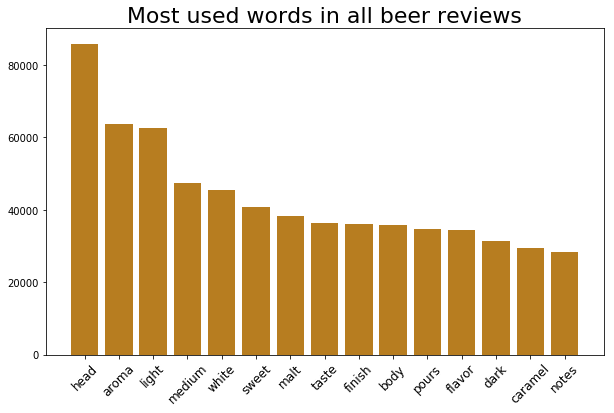

In [20]:
plt.figure(figsize=(10,6))
plt.bar(topwords_df['word'][:15], topwords_df['frequency'][:15], color='#B77D20')
plt.title("Most used words in all beer reviews", size=22)
plt.xticks(size=12, rotation=45);

Note: A pure content recommendation system was made looking at beer styles and other attributes such as ABV. It works but the beer style characteristics are overweighted heavily; thus you only get other India Pale Ale's if you're looking for similar beers to Atlas Brewing Home Rule.